In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


# Imports

In [2]:
%%capture
!pip install -U feature-engine

In [3]:
from reducing import Reducer
from features import get_time_features
from utils import get_target
import os
import pandas as pd
import numpy as np
from copy import deepcopy
import category_encoders as ce
from feature_engine.creation import CyclicalTransformer
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline

from reducing import Reducer

# Parameters

In [4]:
USE_FULL = True
data_path = 'data'
train_filename = 'training_set_VU_DM.csv'
test_filename = 'test_set_VU_DM.csv'

CAT_FEATURES = ['site_id',
                'visitor_location_country_id',
                'prop_country_id',
                'prop_id',
                'srch_destination_id']

bool_cols = ['prop_brand_bool',
             'promotion_flag',
             'srch_saturday_night_bool',
             'random_bool']

drop_cols = ['position', 'click_bool',
             'gross_bookings_usd', 'booking_bool']

group_col = 'srch_id'
time_col = 'date_time'

# Data reading

In [5]:
dtps = {'srch_id': 'uint32',
        'date_time': 'object',
        'site_id': 'uint8',
        'visitor_location_country_id': 'uint8',
        'visitor_hist_starrating': 'float64',
        'visitor_hist_adr_usd': 'float64',
        'prop_country_id': 'uint8',
        'prop_id': 'uint32',
        'prop_starrating': 'uint8',
        'prop_review_score': 'float64',
        'prop_brand_bool': 'uint8',
        'prop_location_score1': 'float32',
        'prop_location_score2': 'float64',
        'prop_log_historical_price': 'float32',
        'position': 'uint8',
        'price_usd': 'float32',
        'promotion_flag': 'uint8',
        'srch_destination_id': 'uint16',
        'srch_length_of_stay': 'uint8',
        'srch_booking_window': 'uint16',
        'srch_adults_count': 'uint8',
        'srch_children_count': 'uint8',
        'srch_room_count': 'uint8',
        'srch_saturday_night_bool': 'uint8',
        'srch_query_affinity_score': 'float64',
        'orig_destination_distance': 'float64',
        'random_bool': 'uint8',
        'comp1_rate': 'Int8',
        'comp1_inv': 'Int8',
        'comp1_rate_percent_diff': 'UInt16',
        'comp2_rate': 'Int8',
        'comp2_inv': 'Int8',
        'comp2_rate_percent_diff': 'UInt32',
        'comp3_rate': 'Int8',
        'comp3_inv': 'Int8',
        'comp3_rate_percent_diff': 'UInt32',
        'comp4_rate': 'Int8',
        'comp4_inv': 'Int8',
        'comp4_rate_percent_diff': 'UInt32',
        'comp5_rate': 'Int8',
        'comp5_inv': 'Int8',
        'comp5_rate_percent_diff': 'UInt32',
        'comp6_rate': 'Int8',
        'comp6_inv': 'Int8',
        'comp6_rate_percent_diff': 'UInt16',
        'comp7_rate': 'Int8',
        'comp7_inv': 'Int8',
        'comp7_rate_percent_diff': 'UInt16',
        'comp8_rate': 'Int8',
        'comp8_inv': 'Int8',
        'comp8_rate_percent_diff': 'UInt32',
        'click_bool': 'uint8',
        'gross_bookings_usd': 'float64',
        'booking_bool': 'uint8'}

In [6]:
%%time

if USE_FULL:
    df = pd.read_csv(os.path.join(data_path, train_filename),
                     dtype=dtps
                     )
else:
    import random
    p = 0.01
    df = pd.read_csv(os.path.join(data_path, train_filename),
                     header=0,
                     skiprows=lambda i: i > 0 and random.random() > p)
    
df.drop(drop_cols, axis=1)
df.shape

CPU times: user 36.2 s, sys: 1.57 s, total: 37.8 s
Wall time: 38.1 s


(4958347, 54)

In [7]:
subm_df = pd.read_csv(os.path.join(data_path, test_filename))
subm_df.shape

(4959183, 50)

In [8]:
# split later. be very careful
df['subm'] = False
subm_df['subm'] = True
df = pd.concat([df, subm_df])

df['date_time'] = pd.to_datetime(df['date_time'])

df.shape

(9917530, 55)

In [9]:
df.memory_usage().sum() / 1024**2

4398.013544082642

# Missing values

In [10]:
df['was_sold_in_that_period'] = df['prop_log_historical_price'].apply(bool)
df['prop_log_historical_price'].replace(0, np.nan, inplace=True)
df['prop_starrating'].replace(0, np.nan, inplace=True)
df['visitor_hist_adr_usd'].replace(0, np.nan, inplace=True)

In [11]:
df.isna().any(axis=0)

srch_id                        False
date_time                      False
site_id                        False
visitor_location_country_id    False
visitor_hist_starrating         True
visitor_hist_adr_usd            True
prop_country_id                False
prop_id                        False
prop_starrating                 True
prop_review_score               True
prop_brand_bool                False
prop_location_score1           False
prop_location_score2            True
prop_log_historical_price       True
position                        True
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
srch_query_affinity_score       True
orig_destination_distance       True
random_bool                    False
c

# Time-independent feature engineering

## Decompose time

In [12]:
%%time

# various time-related columns are added to the df
df = get_time_features(df, 'date_time')

# time column is encoded as some algorithms don't work with datetime. 
# keep both. each specific model may load needed columns
enc = ce.OrdinalEncoder(cols=['date_time'])
df.sort_values(['date_time'], inplace=True)
df = enc.fit_transform(df)
# df.drop('date_time', axis=1, inplace=True)

CPU times: user 5min 3s, sys: 29.4 s, total: 5min 33s
Wall time: 5min 44s


In [13]:
pd.set_option('max_columns', None)
df.head()

srch_id  date_time  site_id  visitor_location_country_id  \
485242    32491          1       24                          216   
485243    32491          1       24                          216   
485244    32491          1       24                          216   
485245    32491          1       24                          216   
485246    32491          1       24                          216   

        visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
485242                      NaN                   NaN              225   
485243                      NaN                   NaN              225   
485244                      NaN                   NaN              225   
485245                      NaN                   NaN              225   
485246                      NaN                   NaN              225   

        prop_id  prop_starrating  prop_review_score  prop_brand_bool  \
485242      327              4.0                4.5                0   
485243    20797              3.0                3.0                0   
485244    24202              3.0                0.0                0   
485245    33813              5.0                4.5                1   
485246    36599              3.0                4.0                0   

        prop_location_score1  prop_location_score2  prop_log_historical_price  \
485242                  3.66                0.1358                       5.31   
485243                  4.65                0.1955                       4.97   
485244                  4.73                0.3831                       4.97   
485245                  4.76                0.3524                       6.13   
485246                  4.64                0.3488                       5.13   

        position  price_usd  promotion_flag  srch_destination_id  \
485242       NaN     142.71               0                14083   
485243       NaN      79.22               0                14083   
485244       NaN      93.07               1                14083   
485245       NaN     278.63               0                14083   
485246       NaN     100.92               1                14083   

        srch_length_of_stay  srch_booking_window  srch_adults_count  \
485242                    2                   16                  1   
485243                    2                   16                  1   
485244                    2                   16                  1   
485245                    2                   16                  1   
485246                    2                   16                  1   

        srch_children_count  srch_room_count  srch_saturday_night_bool  \
485242                    0                1                         1   
485243                    0                1                         1   
485244                    0                1                         1   
485245                    0                1                         1   
485246                    0                1                         1   

        srch_query_affinity_score  orig_destination_distance  random_bool  \
485242                        NaN                        NaN            0   
485243                        NaN                        NaN            0   
485244                        NaN                        NaN            0   
485245                        NaN                        NaN            0   
485246                        NaN                        NaN            0   

        comp1_rate  comp1_inv  comp1_rate_percent_diff  comp2_rate  comp2_inv  \
485242        <NA>       <NA>                     <NA>         1.0        0.0   
485243        <NA>       <NA>                     <NA>        <NA>       <NA>   
485244        <NA>       <NA>                     <NA>        <NA>       <NA>   
485245        <NA>       <NA>                     <NA>         0.0        0.0   
485246        <NA>       <NA>                     <NA>         1.0        0.0   

   

## Time cyclicals

In [14]:
max_values_dict = {'day': 31,
                   'month': 12,
                   'quarter': 4,
                   'week': 52,
                   'dow': 7,
                   'doy': 366,
                   'season_num': 4}

cyclical = CyclicalTransformer(variables=list(max_values_dict.keys()), 
                               drop_original=False,
                               max_values=max_values_dict)

df = cyclical.fit_transform(df)
df.head()

/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:67: FutureWarning: Class CyclicalTransformer is deprecated; CyclicalTransformer() is deprecated in version 1.3 and will be removed in version 1.4. Use CyclicalFeatures() instead.
  warnings.warn(msg, category=FutureWarning)


srch_id  date_time  site_id  visitor_location_country_id  \
485242    32491          1       24                          216   
485243    32491          1       24                          216   
485244    32491          1       24                          216   
485245    32491          1       24                          216   
485246    32491          1       24                          216   

        visitor_hist_starrating  visitor_hist_adr_usd  prop_country_id  \
485242                      NaN                   NaN              225   
485243                      NaN                   NaN              225   
485244                      NaN                   NaN              225   
485245                      NaN                   NaN              225   
485246                      NaN                   NaN              225   

        prop_id  prop_starrating  prop_review_score  prop_brand_bool  \
485242      327              4.0                4.5                0   
485243    20797              3.0                3.0                0   
485244    24202              3.0                0.0                0   
485245    33813              5.0                4.5                1   
485246    36599              3.0                4.0                0   

        prop_location_score1  prop_location_score2  prop_log_historical_price  \
485242                  3.66                0.1358                       5.31   
485243                  4.65                0.1955                       4.97   
485244                  4.73                0.3831                       4.97   
485245                  4.76                0.3524                       6.13   
485246                  4.64                0.3488                       5.13   

        position  price_usd  promotion_flag  srch_destination_id  \
485242       NaN     142.71               0                14083   
485243       NaN      79.22               0                14083   
485244       NaN      93.07               1                14083   
485245       NaN     278.63               0                14083   
485246       NaN     100.92               1                14083   

        srch_length_of_stay  srch_booking_window  srch_adults_count  \
485242                    2                   16                  1   
485243                    2                   16                  1   
485244                    2                   16                  1   
485245                    2                   16                  1   
485246                    2                   16                  1   

        srch_children_count  srch_room_count  srch_saturday_night_bool  \
485242                    0                1                         1   
485243                    0                1                         1   
485244                    0                1                         1   
485245                    0                1                         1   
485246                    0                1                         1   

        srch_query_affinity_score  orig_destination_distance  random_bool  \
485242                        NaN                        NaN            0   
485243                        NaN                        NaN            0   
485244                        NaN                        NaN            0   
485245                        NaN                        NaN            0   
485246                        NaN                        NaN            0   

        comp1_rate  comp1_inv  comp1_rate_percent_diff  comp2_rate  comp2_inv  \
485242        <NA>       <NA>                     <NA>         1.0        0.0   
485243        <NA>       <NA>                     <NA>        <NA>       <NA>   
485244        <NA>       <NA>                     <NA>        <NA>       <NA>   
485245        <NA>       <NA>                     <NA>         0.0        0.0   
485246        <NA>       <NA>                     <NA>         1.0        0.0   

   

## Competitors

In [15]:
for i in range(1, 9):
    df[f'comp{i}_rate_percent_diff_signed'] = df[f'comp{i}_rate'] * df[f'comp{i}_rate_percent_diff']
    df.drop([f'comp{i}_rate'], axis=1, inplace=True)  # bcs it's just a sign for the new feature

In [16]:
df[sorted([c for c in df.columns if 'comp' in c and 'rate' in c])].head()

comp1_rate_percent_diff  comp1_rate_percent_diff_signed  \
485242                     <NA>                            <NA>   
485243                     <NA>                            <NA>   
485244                     <NA>                            <NA>   
485245                     <NA>                            <NA>   
485246                     <NA>                            <NA>   

        comp2_rate_percent_diff  comp2_rate_percent_diff_signed  \
485242                      8.0                             8.0   
485243                     <NA>                            <NA>   
485244                     <NA>                            <NA>   
485245                      7.0                             0.0   
485246                      6.0                             6.0   

        comp3_rate_percent_diff  comp3_rate_percent_diff_signed  \
485242                      4.0                             4.0   
485243                      2.0                            -2.0   
485244                     <NA>                            <NA>   
485245                      3.0                             3.0   
485246                      8.0                             0.0   

        comp4_rate_percent_diff  comp4_rate_percent_diff_signed  \
485242                      4.0                             4.0   
485243                      9.0                             9.0   
485244                      9.0                             9.0   
485245                     15.0                            15.0   
485246                     11.0                            11.0   

        comp5_rate_percent_diff  comp5_rate_percent_diff_signed  \
485242                      7.0                             7.0   
485243                     <NA>                            <NA>   
485244                     <NA>                            <NA>   
485245                      7.0                             0.0   
485246                      2.0                             2.0   

        comp6_rate_percent_diff  comp6_rate_percent_diff_signed  \
485242                     <NA>                            <NA>   
485243                     <NA>                            <NA>   
485244                     <NA>                            <NA>   
485245                     <NA>                            <NA>   
485246                     <NA>                            <NA>   

        comp7_rate_percent_diff  comp7_rate_percent_diff_signed  \
485242                     <NA>                            <NA>   
485243                     <NA>                            <NA>   
485244                     <NA>                            <NA>   
485245                     <NA>                            <NA>   
485246                     <NA>                            <NA>   

        comp8_rate_percent_diff  comp8_rate_percent_diff_signed  
485242                     <NA>                            <NA>  
485243                     <NA>                            <NA>  
485244                     <NA>                            <NA>  
485245                     <NA>                            <NA>  
485246                     <NA>                            <NA>

## Money transformations

In [17]:
def num_transformations(df, cols, powers=[0.33, 0.5, 2, 3], log_bases=[2, 10, np.e], 
                        do_reciprocal=True, do_exp=True):
    for c in cols:
        for p in powers:
            if (p <=2) or (p > 2 and all(df[c] < 100)): 
                df[f'{c}_pow_{p}'] = df[c]**p
        
        for log_base in log_bases:
            df[f'{c}_log_{log_base}'] = np.log(df[c]) / np.log(log_base)
        
        if do_reciprocal:
            df[c+'_reciprocal'] = 1/(df[c] + 1e-6)
        
        if do_exp and all(df[c] < 10): 
            df[c+'_exp'] = np.exp(df[c])
    return df

In [18]:
df = num_transformations(df,
                         ['price_usd', 'visitor_hist_adr_usd',
                          'prop_log_historical_price'],
                         powers=[0.33, 0.5, 2, 3],
                         log_bases=[2, 10, round(np.e, 2)])

/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df = num_transformations(df,
                         [f'comp{i}_rate_percent_diff' for i in range(1, 9)],
                         powers=[],
                         log_bases=[2, 10], 
                         do_reciprocal=False,
                         do_exp=False)

**visitor_hist_adr_usd** - The mean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer  

**price_usd** - Displayed price of the hotel for the given search.  Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay

In [20]:
df['price_diff_to_usr_hist'] = df['price_usd'] - df['visitor_hist_adr_usd']
df['price_ratio_to_usr_hist'] = df['price_usd'] / (df['visitor_hist_adr_usd'] + 1e-2)

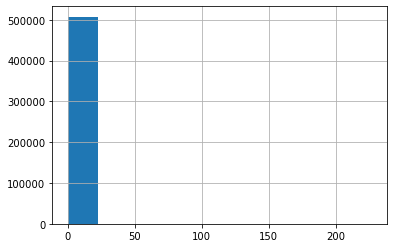

In [21]:
df['price_ratio_to_usr_hist'].hist();

**prop_log_historical_price** - The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period.  

In [22]:
df['price_diff_to_place_hist_price'] = df['price_usd'] - np.exp(df['prop_log_historical_price'])
df['place_hist_price_diff_usr_hist'] = np.exp(df['prop_log_historical_price']) - df['visitor_hist_adr_usd']

**gross_booking_usd** - Total value of the transaction.  This can differ from the price_usd due to taxes, fees, conventions on multiple day bookings and purchase of a room type other than the one shown in the search
ID of the destination where the hotel search was performed

In [23]:
# totally missed in submission df
# df['usr_extra_pay'] = df['gross_bookings_usd'] - df['price_usd']

## Days of staying

**srch_length_of_stay** - Number of nights stay that was searched


**srch_booking_window** - Number of days in the future the hotel stay started from the search date

In [24]:
df['booking_weeks_ahead'] = df['srch_booking_window'] / 7
df['booking_months_ahead'] = df['srch_booking_window'] / 30

df['len_of_stay_to_booking_ahead_ratio'] = df['srch_booking_window'] / df['srch_length_of_stay']
df['len_of_stay_to_booking_ahead_diff'] = df['srch_booking_window'] - df['srch_length_of_stay']

## Family

**srch_adults_count** - The number of adults specified in the hotel room

 
**srch_children_count** - The number of (extra occupancy) children specified in the hotel room

 
**srch_room_count** - Number of hotel rooms specified in the search

In [25]:
df['children_per_adult'] = df['srch_children_count'] / df['srch_adults_count']
df['total_people'] = df['srch_children_count'] + df['srch_adults_count']
df['people_per_room'] = df['total_people'] / df['srch_room_count']

## Others

**srch_query_affinity_score** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)

In [26]:
df['srch_query_affinity_score_prob'] = np.exp(df['srch_query_affinity_score'])

# Data split

In [28]:
df.to_pickle(os.path.join(data_path, 'full_df.pickle'))

In [29]:
df = Reducer(use_categoricals=False, n_jobs=1).reduce(df, verbose=True)#.dtypes.apply(lambda x: x.name).to_dict()

convert srch_id to <class 'numpy.uint32'>
convert date_time to <class 'numpy.uint32'>
convert site_id to <class 'numpy.uint8'>
convert visitor_location_country_id to <class 'numpy.uint8'>
convert visitor_hist_starrating to <class 'numpy.float32'>
Exception for visitor_hist_starrating: <class 'numpy.float32'>
convert visitor_hist_adr_usd to <class 'numpy.float32'>
Exception for visitor_hist_adr_usd: <class 'numpy.float32'>
convert prop_country_id to <class 'numpy.uint8'>
convert prop_id to <class 'numpy.uint32'>
convert prop_starrating to <class 'numpy.uint8'>
convert prop_review_score to <class 'numpy.float32'>
Exception for prop_review_score: <class 'numpy.float32'>
convert prop_brand_bool to <class 'numpy.uint8'>
convert prop_location_score1 to <class 'numpy.float32'>
convert prop_location_score2 to <class 'numpy.float32'>
Exception for prop_location_score2: <class 'numpy.float32'>
convert prop_log_historical_price to <class 'numpy.float32'>
Exception for prop_log_historical_price: <

Exception for comp3_rate_percent_diff_log_2: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp3_rate_percent_diff_log_10: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp4_rate_percent_diff_log_2: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp4_rate_percent_diff_log_10: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp5_rate_percent_diff_log_2: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp5_rate_percent_diff_log_10: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp6_rate_percent_diff_log_2: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp6_rate_percent_diff_log_10: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp7_rate_percent_diff_log_2: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp7_rate_percent_diff_log_10: Cannot interpret 'Float64Dtype()' as a data type
Exception for comp8_rate_percent_diff_log_2: Cannot int

In [ ]:
# def downcast(df):
#     for column in df:
#         if ('float' in df[column].dtype.name.lower()) or (df[column].isna().any()):
#             df[column] = pd.to_numeric(df[column].astype(float), downcast='float')
#         elif df[column].dtype.name.lower().startswith('uint'):
#             df[column] = pd.to_numeric(df[column], downcast='unsigned')
#         elif df[column].dtype.name.lower().startswith('int'):
#             df[column] = pd.to_numeric(df[column], downcast='integer')
#     return df

In [30]:
df.shape

(9917530, 138)

In [31]:
df.sort_values([group_col, time_col], inplace=True)

In [32]:
# further all feature engineering will be separate

subm_df = deepcopy(df[df['subm'] == True])
df = deepcopy(df[df['subm'] == False])

subm_df.drop(['subm'], axis=1, inplace=True)
df.drop(['subm'], axis=1, inplace=True)

df.shape, subm_df.shape

((4958347, 137), (4959183, 137))

In [33]:
from utils import train_test_group_split, get_target

X = df.drop(drop_cols, axis=1)
subm_df = subm_df.drop(drop_cols, axis=1)
groups = X[group_col]

In [36]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

# df.apply(func)
# df.parallel_apply(func)
# y = df.apply(get_target, axis=1)
y = df[['booking_bool', 'click_bool']].parallel_apply(get_target, axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Process ForkPoolWorker-15:
Traceback (most recent call last):
  File "/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: invalid load key, '\x04'.
Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/Oleg_Litvinov1/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Us

In [37]:
X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test = train_test_group_split(X, y, groups,
                                                                                                 group_array=groups,
                                                                                                 train_size=0.9)
# del X, y

X_train, X_val, y_train, y_val, groups_train, groups_val = train_test_group_split(X_train_val,
                                                                                  y_train_val,
                                                                                  groups_train_val,
                                                                                  group_array=groups_train_val,
                                                                                  train_size=0.9)

In [41]:
# make sure that this is empty
assert set(X_train[group_col]).intersection(set(X_test[group_col])) == set()

In [51]:
X_train.shape, X_val.shape, X_test.shape, subm_df.shape

((4016262, 133), (446248, 133), (495837, 133), (4959183, 137))

In [ ]:
assert X_train.shape[1] == X_val.shape[1]
asser X_val.shape[1] == X_test.shape[1]

# Feature engineering with respect to the time 

# Correlations

In [50]:
profile = ProfileReport(X_train, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
for c in df.columns:
    df_nans = df[c].isna().mean().round(4) * 100
    subm_df_nans = subm_df[c].isna().mean().round(4) * 100
    if df_nans == subm_df_nans == 0:
        continue
    print(f"{c}: {df_nans} in train, {subm_df_nans} in test")

visitor_hist_starrating: 94.92 in train, 94.89 in test
visitor_hist_adr_usd: 94.89999999999999 in train, 94.87 in test
prop_starrating: 3.42 in train, 3.39 in test
prop_review_score: 0.15 in train, 0.15 in test
prop_location_score2: 21.990000000000002 in train, 21.94 in test
prop_log_historical_price: 14.399999999999999 in train, 14.45 in test
position: 0.0 in train, 100.0 in test
srch_query_affinity_score: 93.60000000000001 in train, 93.58 in test
orig_destination_distance: 32.43 in train, 32.440000000000005 in test
comp1_inv: 97.39 in train, 97.48 in test
comp1_rate_percent_diff: 98.1 in train, 98.18 in test
comp2_inv: 57.04 in train, 57.230000000000004 in test
comp2_rate_percent_diff: 88.78 in train, 88.84 in test
comp3_inv: 66.7 in train, 66.91 in test
comp3_rate_percent_diff: 90.46 in train, 90.5 in test
comp4_inv: 93.07 in train, 92.97 in test
comp4_rate_percent_diff: 97.36 in train, 97.32 in test
comp5_inv: 52.400000000000006 in train, 52.400000000000006 in test
comp5_rate_perce

In [75]:
df['visitor_hist_adr_usd'].isna().mean().round(4) * 100

94.89999999999999

In [76]:
df['price_ratio_to_usr_hist'].isna().mean().round(4) * 100

94.89999999999999

In [77]:
subm_df['visitor_hist_adr_usd'].isna().mean().round(4) * 100

94.87

In [78]:
subm_df['price_ratio_to_usr_hist'].isna().mean().round(4) * 100

94.87

In [72]:
df['price_ratio_to_usr_hist'].agg([min, max])

min      0.011829
max    177.935106
Name: price_ratio_to_usr_hist, dtype: float64

In [73]:
subm_df['price_ratio_to_usr_hist'].agg([min, max])

min      0.011759
max    226.912691
Name: price_ratio_to_usr_hist, dtype: float64

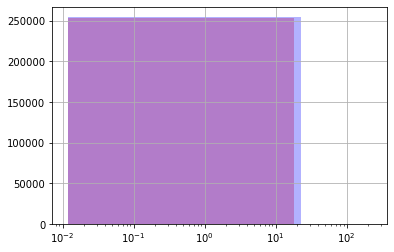

In [71]:
df['price_ratio_to_usr_hist'].hist(alpha=0.3, color='r');
subm_df['price_ratio_to_usr_hist'].hist(alpha=0.3, color='b');
plt.xscale('log')

# Save tables

In [49]:
X_train.to_pickle(os.path.join(data_path, 'X_train.pickle'))
y_train.to_frame('target').to_pickle(os.path.join(data_path, 'y_train.pickle'))
# groups_train.to_pickle(os.path.join(data_path, 'groups_train.pickle'))
print('train is done')

X_val.to_pickle(os.path.join(data_path, 'X_val.pickle'))
y_val.to_frame('target').to_pickle(os.path.join(data_path, 'y_val.pickle'))
# groups_val.to_pickle(os.path.join(data_path, 'groups_val.pickle'))
print('val is done')

X_test.to_pickle(os.path.join(data_path, 'X_test.pickle'))
y_test.to_frame('target').to_pickle(os.path.join(data_path, 'y_test.pickle'))
# groups_test.to_pickle(os.path.join(data_path, 'groups_test.pickle'))
print('test is done')

subm_df.to_pickle(os.path.join(data_path, 'submission_df_preprocessed.pickle'))
print('submission is done')

train is done
val is done
test is done
submission is done
